In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import numpy as np
import csv
import antropy as ant
import math
import pandas as pd
import matplotlib.pyplot as plt

In [15]:
begin, end = 1, 61 # (begin is inclusive, end is exclusive)
num_people = 14
count_samples = {
    "active": 8,
    "meditate": 8,
    "neutral": 8
}

class Sample:
    def __init__(self):
        self.data = {
            'RawEEG': [],
            'Alpha': [],
            'Low Beta': [],
            'High Beta': [],
            'Gamma': [],
            'Theta': [],
            'Delta': [],
            'Meditation': [],
            'Attention': []
        }

    def recordDataPoint(self, RawEEG, Attention, Meditation, Alpha, Delta, Theta, LowBeta, HighBeta, Gamma):
        self.data['RawEEG'].append(float(RawEEG))
        self.data['Attention'].append(float(Attention))
        self.data['Meditation'].append(float(Meditation))
        self.data['Alpha'].append(float(Alpha))
        self.data['Delta'].append(float(Delta))
        self.data['Theta'].append(float(Theta))
        self.data['Low Beta'].append(float(LowBeta))
        self.data['High Beta'].append(float(HighBeta))
        self.data['Gamma'].append(float(Gamma))

    '''
    Record a line of data from the CSV output, which takes form RawEEG, Alpha, Delta, Gamma, Low Beta, High Beta, Theta, Attention, Meditation

    '''
    def recordDataLine(self, line):
        self.recordDataPoint(line[0], line[7], line[8], line[1], line[2], line[6], line[4], line[5], line[3])
    
    def getEEG(self):
        return self.data['RawEEG']
    
    def getAttention(self):
        return self.data["Attention"]
    
    def getMeditation(self):
        return self.data["Meditation"]
    
    def getAlpha(self):
        return self.data["Alpha"]
    
    def getDelta(self):
        return self.data["Delta"]
    
    def getTheta(self):
        return self.data["Theta"]
    
    def getLowBeta(self):
        return self.data["Low Beta"]
    
    def getHighBeta(self):
        return self.data["High Beta"]
    
    def getGamma(self):
        return self.data["Gamma"]

    def get(self, key):
        return self.data[key]

    '''
    Filter out all outliers, as defined by being outside 3*std from the mean, and replace with mean of the samples around them
    '''
    def filter_outliers(self):
        sampleBad = False
        for key in ['RawEEG', 'Alpha', 'Theta', 'Low Beta', 'High Beta', "Gamma", 'Delta']:
            data = self.data[key]
            
            filtered = []
            for x in data:

                iqr = np.subtract(*np.percentile(data, [75,25]))
                med = np.median(data)

                lowerBound = med - 1.5 * iqr
                upperBound = med + 1.5 * iqr

                if abs(x - np.median(data)) > 2 * np.std(data) or x < lowerBound or x > upperBound:
                    filtered.append(med)
                else:
                    filtered.append(x)
            self.data[key] = filtered
        return sampleBad

In [16]:
# {personNum : {state: [sampleNums]}}
# 0 = key for throwing away all samples of that state

badSamples = {
    1: {"active": [5], "neutral": [2], "meditate": []},
    2: {"active": [0], "neutral": [0], "meditate": [0]},
    3: {"active": [1, 4], "neutral": [1], "meditate": [5, 6, 7, 8]},
    4: {"active": [2], "neutral": [7], "meditate": [1, 8]}, # maybe n1
    5: {"active": [], "neutral": [], "meditate": []}, # i love you person 5 
    6: {"active": [], "neutral": [2, 6], "meditate": []},
    7: {"active": [5], "neutral": [4, 6, 7], "meditate": [1, 3, 4, 8]}, # think about killing some of this data
    8: {"active": [5], "neutral": [1], "meditate": []}, # maybe m5 and m8
    9: {"active": [], "neutral": [], "meditate": []}, 
    10: {"active": [6, 8], "neutral": [4, 5, 6], "meditate": []},
    11: {"active": [4], "neutral": [4, 8], "meditate": [1, 2, 3, 5, 7]},
    12: {"active": [2, 3, 8], "neutral": [0], "meditate": [6]}, # maybe n0
    13: {"active": [], "neutral": [8], "meditate": []},
    14: {"active": [4, 5, 8], "neutral": [0], "meditate": [1, 2, 8]}
}

In [ ]:
data = []
dataLabels = []

def transcribeFileToSample(personN: int, sampleN: int, state: str):
    sample_data = Sample()

    with open("data/all_data/" + state + "_" + str(personN) + "_" + str(sampleN) + ".csv") as f:
        reader = csv.reader(f)

        header = next(reader)
        
        for row in reader:
            sample_data.recordDataLine(row)
            
        if (0 not in badSamples[personN][state] and sampleN not in badSamples[personN][state]):

            for key in sample_data.data:
                sample_data.data[key] = sample_data.data[key][begin:end]

            sample_data.filter_outliers()

            data.append(sample_data)
            dataLabels.append(state)

for person in range(num_people):
    for state in count_samples:
        for i in range(count_samples[state]):
            transcribeFileToSample(person + 1, i + 1, state)

In [ ]:
dataExtracted = []

def safety_check(x):
    if math.isnan(x): return 0
    if math.isinf(x): return 99999999999
    return x

for point in data:
    extractedPoint = []

    for key in ['RawEEG', 'Alpha', 'Delta', 'Theta', 'Low Beta', 'High Beta', 'Gamma']:
        for func in [np.mean, np.std, ant.sample_entropy, ant.petrosian_fd]:
            extractedPoint.append(safety_check(func(point.get(key))))

    extractedPoint.append(safety_check(ant.spectral_entropy(point.getEEG(), sf=1)))
    
    dataExtracted.append(extractedPoint)

In [ ]:
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

train, test, trainLabels, testLabels = train_test_split(dataExtracted, dataLabels, test_size=0.20)

rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(train, trainLabels)

In [ ]:
rf_random.best_params_

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

param_grid = {
    'pca__n_components': [1, 2, 3, 4, 5, 10, 15, 20],
    'rf__bootstrap': [True], 
    'rf__max_depth': [20, 30, 40, 50, 60, 70, 80, 90, 100, 110],
    'rf__max_features': ['auto', 'sqrt'], 
    'rf__min_samples_leaf': [1],
    'rf__min_samples_split': [2], 
    'rf__n_estimators': range(600, 2001, 200)
}

scaler = StandardScaler()
pca = PCA()
rf = RandomForestClassifier()

pipe = Pipeline(steps = [('scaler', scaler), ('pca', pca), ('rf', rf)])

search = RandomizedSearchCV(estimator = pipe, param_distributions = param_grid, n_iter = 100, 
                          cv = 3, n_jobs = -1, verbose = 2)
search.fit(dataExtracted, dataLabels)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END pca__n_components=1, rf__bootstrap=True, rf__max_depth=60, rf__max_features=auto, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=600; total time=   2.2s
[CV] END pca__n_components=1, rf__bootstrap=True, rf__max_depth=60, rf__max_features=auto, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=600; total time=   2.2s
[CV] END pca__n_components=1, rf__bootstrap=True, rf__max_depth=60, rf__max_features=auto, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=600; total time=   2.3s
[CV] END pca__n_components=4, rf__bootstrap=True, rf__max_depth=20, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=1000; total time=   3.7s
[CV] END pca__n_components=4, rf__bootstrap=True, rf__max_depth=20, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=1000; total time=   3.4s
[CV] END pca__n_components=4, 

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('pca', PCA()),
                                             ('rf', RandomForestClassifier())]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'pca__n_components': [1, 2, 3, 4, 5, 10,
                                                              15, 20],
                                        'rf__bootstrap': [True],
                                        'rf__max_depth': [20, 30, 40, 50, 60,
                                                          70, 80, 90, 100,
                                                          110],
                                        'rf__max_features': ['auto', 'sqrt'],
                                        'rf__min_samples_leaf': [1],
                                        'rf__min_samples_split': [2],
                                        'rf__n_estimators': range

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/indexes/base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


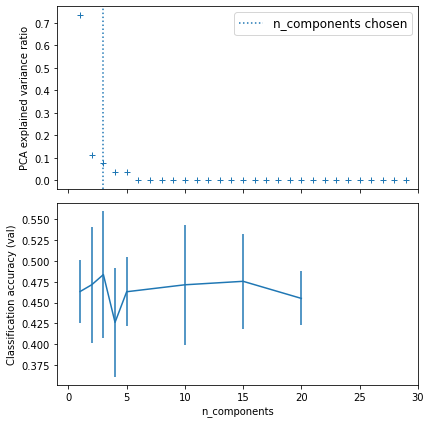

In [18]:
# Plot the PCA spectrum
pca.fit(dataExtracted)

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax0.plot(
    np.arange(1, pca.n_components_ + 1), pca.explained_variance_ratio_, "+", linewidth=2
)
ax0.set_ylabel("PCA explained variance ratio")

ax0.axvline(
    search.best_estimator_.named_steps["pca"].n_components,
    linestyle=":",
    label="n_components chosen",
)
ax0.legend(prop=dict(size=12))

# For each number of components, find the best classifier results
results = pd.DataFrame(search.cv_results_)
components_col = "param_pca__n_components"
best_clfs = results.groupby(components_col).apply(
    lambda g: g.nlargest(1, "mean_test_score")
)

best_clfs.plot(
    x=components_col, y="mean_test_score", yerr="std_test_score", legend=False, ax=ax1
)
ax1.set_ylabel("Classification accuracy (val)")
ax1.set_xlabel("n_components")

plt.xlim(-1, 30)

plt.tight_layout()
plt.show()

In [ ]:
search.best_params_


{'rf__n_estimators': 1800,
 'rf__min_samples_split': 2,
 'rf__min_samples_leaf': 1,
 'rf__max_features': 'auto',
 'rf__max_depth': 70,
 'rf__bootstrap': True,
 'pca__n_components': 3}

In [ ]:
best_grid = search.best_estimator_
best_grid

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=3)),
                ('rf',
                 RandomForestClassifier(max_depth=70, n_estimators=1800))])